In [1]:
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

To proceed with the exploratory data analysis (EDA), I'll outline the following steps:

<ul>
    <li>
Data Cleaning
    </li>
    <li>
Descriptive Statistics
    </li>
    <li>
Categorical Analysis
    </li>
<li>
Anomaly Detection
    </li>
    <li>
Trend Analysis and Projection
    </li>
    <li>
Visualizations
    </li>
</ul>

## Data Cleaning

In [2]:
# Load the dataset
claims_data = pd.read_csv('claims_sample_data.csv')

# Display the first few rows of the dataset
claims_data.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


There are no missing values in the MONTH, SERVICE_CATEGORY, PAYER, and PAID_AMOUNT columns.

There are 251 missing values in the CLAIM_SPECIALTY column. Given that this column represents a classification of the medical service, it might be reasonable to replace missing values with a placeholder like "Unknown" or "Not Specified".

In [3]:
# Check for missing values in each column
missing_values = claims_data.isnull().sum()

missing_values

MONTH                 0
SERVICE_CATEGORY      0
CLAIM_SPECIALTY     251
PAYER                 0
PAID_AMOUNT           0
dtype: int64

In [4]:
# Replace missing values in CLAIM_SPECIALTY with "Not Specified"
claims_data['CLAIM_SPECIALTY'].fillna('Not Specified', inplace=True)

# Descriptive statistics for PAID_AMOUNT
paid_amount_desc = claims_data['PAID_AMOUNT'].describe()

paid_amount_desc

count    5.215200e+04
mean     3.708707e+03
std      3.449842e+04
min     -4.223000e+04
25%      1.940000e+02
50%      5.860000e+02
75%      1.465000e+03
max      2.268611e+06
Name: PAID_AMOUNT, dtype: float64

From the descriptive statistics for the PAID_AMOUNT column:

<ul>
    <li>The average (mean) claim amount is approximately &dollar;3,708.71. </li>
<li>The standard deviation is &dollar;34,498.42, which indicates a wide spread in the claim amounts.</li>
<li>The minimum claim amount is -&dollar;42,230.00, which indicates that there are some negative claims. These could represent refunds or adjustments.</li>
<li>The 25th percentile claim amount is &dollar;194.00.</li>
<li>The median (50th percentile) claim amount is &dollar;586.00.</li>
<li>The 75th percentile claim amount is &dollar;1,465.00.</li>
<li>The maximum claim amount is a substantial &dollar;2,268,611.00.</li>
</ul>

Next, let's aggregate the data by month and visualize the total claim amounts over time to examine the monthly trends in the total PAID_AMOUNT.

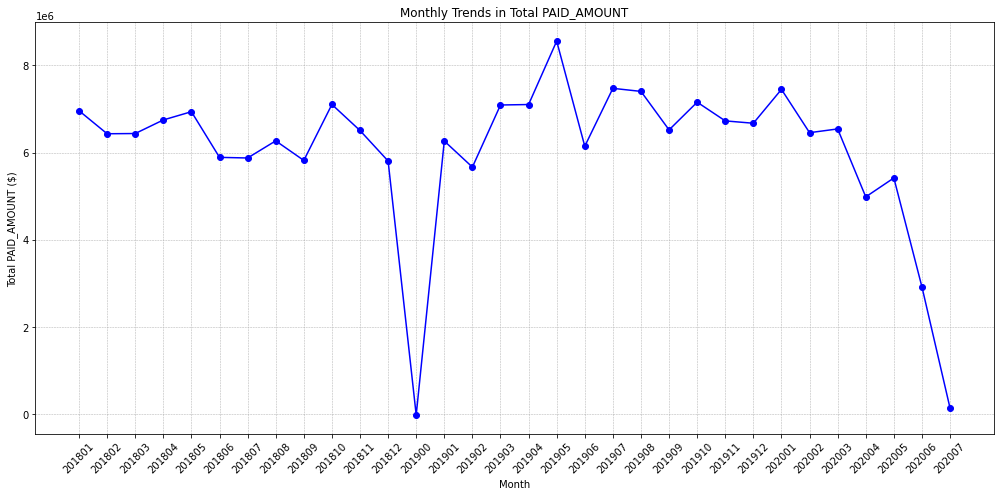

In [5]:
import matplotlib.pyplot as plt

# Group by MONTH and sum PAID_AMOUNT to get total claims per month
monthly_claims = claims_data.groupby('MONTH')['PAID_AMOUNT'].sum().reset_index()

# Plotting monthly trends
plt.figure(figsize=(14, 7))
plt.plot(monthly_claims['MONTH'].astype(str), monthly_claims['PAID_AMOUNT'], marker='o', color='b', linestyle='-')
plt.title('Monthly Trends in Total PAID_AMOUNT')
plt.xlabel('Month')
plt.ylabel('Total PAID_AMOUNT ($)')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

On the "Month" axis, we have invalid data labeled as "201900". Let's remove it from the dataset. Additionally, there's been a sharp decline over the last three months. This is likely a result of the COVID pandemic. We should account for this anomalous decrease when projecting for the next six months.

In [6]:
# Remove rows where MONTH equals 201900
claims_data = claims_data[claims_data['MONTH'] != 201900]

# Convert MONTH to date format
claims_data['MONTH'] = pd.to_datetime(claims_data['MONTH'], format='%Y%m')

## Descriptive Statistics

Now, let's re-run the data analysis:

Descriptive Statistics: Provide a summary of the PAID_AMOUNT to understand its distribution.

In [7]:
# Descriptive statistics for PAID_AMOUNT after data cleaning
paid_amount_desc_updated = claims_data['PAID_AMOUNT'].describe()

paid_amount_desc_updated

count    5.214100e+04
mean     3.710003e+03
std      3.450187e+04
min     -4.223000e+04
25%      1.940000e+02
50%      5.860000e+02
75%      1.465000e+03
max      2.268611e+06
Name: PAID_AMOUNT, dtype: float64

Almost nothing has been changed. The updated descriptive statistics for the PAID_AMOUNT column are as follows:

<ul>
    <li>The average (mean) claim amount is approximately &dollar;3,710.00. </li>
<li>The standard deviation is &dollar;34,501.87, which indicates a wide spread in the claim amounts.</li>
<li>The minimum claim amount is -&dollar;42,230.00, which indicates that there are some negative claims. These could represent refunds or adjustments.</li>
<li>The 25th percentile claim amount is &dollar;194.00.</li>
<li>The median (50th percentile) claim amount is &dollar;586.00.</li>
<li>The 75th percentile claim amount is &dollar;1,465.00.</li>
<li>The maximum claim amount is a substantial &dollar;2,268,611.00.</li>
</ul>

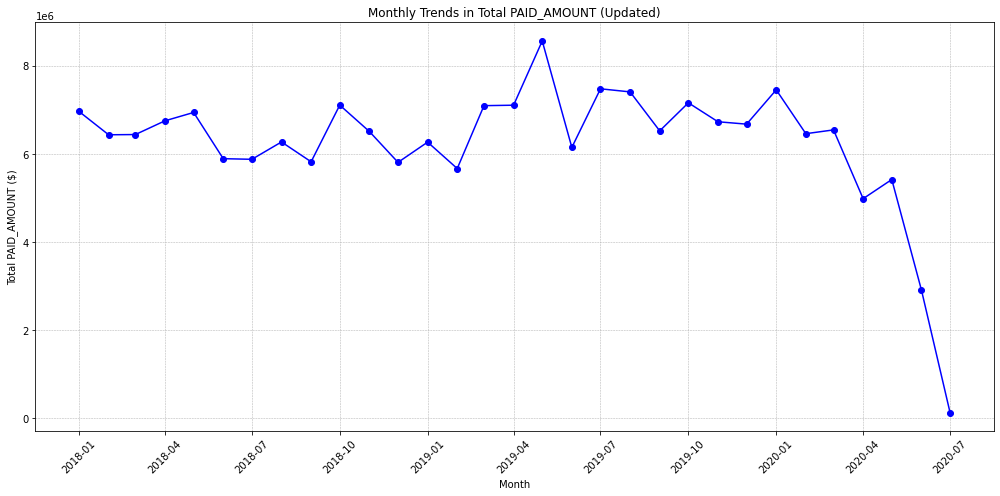

In [8]:
# Group by MONTH and sum PAID_AMOUNT to get updated total claims per month
monthly_claims_updated = claims_data.groupby('MONTH')['PAID_AMOUNT'].sum().reset_index()

# Plotting updated monthly trends
plt.figure(figsize=(14, 7))
plt.plot(monthly_claims_updated['MONTH'], monthly_claims_updated['PAID_AMOUNT'], marker='o', color='b', linestyle='-')
plt.title('Monthly Trends in Total PAID_AMOUNT (Updated)')
plt.xlabel('Month')
plt.ylabel('Total PAID_AMOUNT ($)')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Categorical Analysis

The visualizations provide insights into the distribution of claims across different categories:

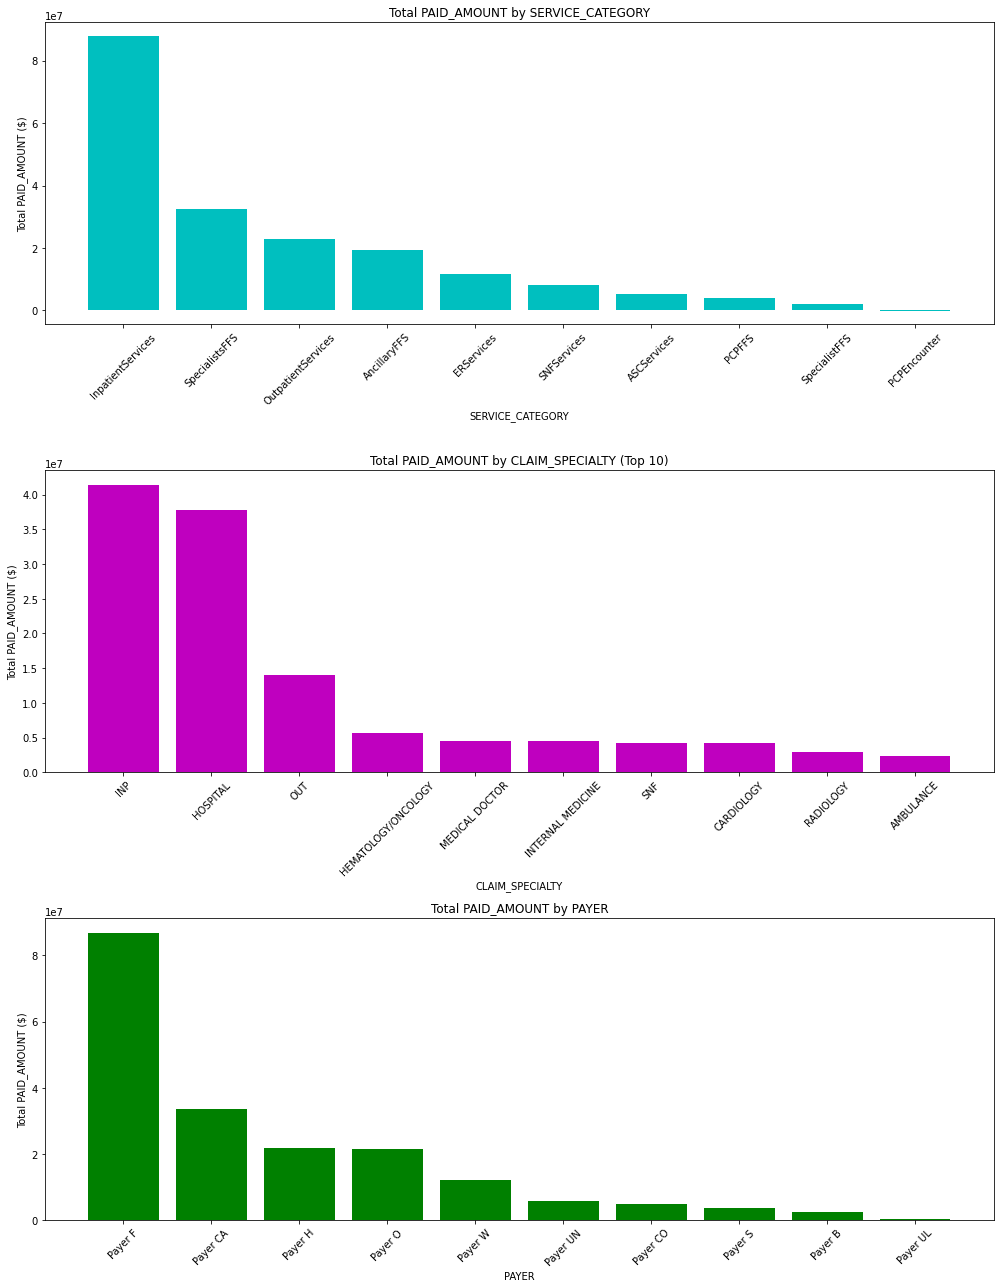

In [9]:
# Summarizing PAID_AMOUNT by SERVICE_CATEGORY
service_category_summary = claims_data.groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].sum().sort_values(ascending=False).reset_index()

# Summarizing PAID_AMOUNT by CLAIM_SPECIALTY (top 10 specialties for visualization)
claim_specialty_summary = claims_data.groupby('CLAIM_SPECIALTY')['PAID_AMOUNT'].sum().sort_values(ascending=False).head(10).reset_index()

# Summarizing PAID_AMOUNT by PAYER
payer_summary = claims_data.groupby('PAYER')['PAID_AMOUNT'].sum().sort_values(ascending=False).reset_index()

# Visualizing the summaries
fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# SERVICE_CATEGORY visualization
ax[0].bar(service_category_summary['SERVICE_CATEGORY'], service_category_summary['PAID_AMOUNT'], color='c')
ax[0].set_title('Total PAID_AMOUNT by SERVICE_CATEGORY')
ax[0].set_xlabel('SERVICE_CATEGORY')
ax[0].set_ylabel('Total PAID_AMOUNT ($)')
ax[0].tick_params(axis='x', rotation=45)

# CLAIM_SPECIALTY visualization (top 10 specialties)
ax[1].bar(claim_specialty_summary['CLAIM_SPECIALTY'], claim_specialty_summary['PAID_AMOUNT'], color='m')
ax[1].set_title('Total PAID_AMOUNT by CLAIM_SPECIALTY (Top 10)')
ax[1].set_xlabel('CLAIM_SPECIALTY')
ax[1].set_ylabel('Total PAID_AMOUNT ($)')
ax[1].tick_params(axis='x', rotation=45)

# PAYER visualization
ax[2].bar(payer_summary['PAYER'], payer_summary['PAID_AMOUNT'], color='g')
ax[2].set_title('Total PAID_AMOUNT by PAYER')
ax[2].set_xlabel('PAYER')
ax[2].set_ylabel('Total PAID_AMOUNT ($)')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<p>
    <b>Total PAID_AMOUNT by SERVICE_CATEGORY:</b>
    <br>The distribution across service categories is evident, with some categories having significantly higher claim amounts than others.</br>
</p>
<p>
    <b>Total PAID_AMOUNT by CLAIM_SPECIALTY (Top 10):</b>
    <br>The visualization focuses on the top 10 specialties based on total paid amounts. A few specialties stand out with considerably higher claim amounts.</br>
</p>

<p>
    <b>Total PAID_AMOUNT by PAYER:</b>
    <br>The distribution of total claim amounts across different payers (insurance companies) shows variability, with some payers having much higher totals than others.</br>
</p>

## Anomaly detection

Based on the statistical approach (looking for values in the PAID_AMOUNT column that fall outside three standard deviations from the mean), we've detected 237 anomalies. These anomalies represent unusually high or low claim amounts compared to the majority of the data.

In [10]:
# Calculate the mean and standard deviation of PAID_AMOUNT
mean_paid_amount = claims_data['PAID_AMOUNT'].mean()
std_paid_amount = claims_data['PAID_AMOUNT'].std()

# Define thresholds for anomalies (3 standard deviations from the mean)
lower_threshold = mean_paid_amount - (3 * std_paid_amount)
upper_threshold = mean_paid_amount + (3 * std_paid_amount)

# Filter out the anomalies
anomalies = claims_data[(claims_data['PAID_AMOUNT'] < lower_threshold) | (claims_data['PAID_AMOUNT'] > upper_threshold)]

# Display the anomalies
anomalies.shape[0]

237

The boxplot for PAID_AMOUNT provides a visual representation of the distribution of claim amounts:
<ul>
<li>The majority of the data (represented by the box) lies within a relatively small range.</li>
<li>There are numerous data points (outliers) that fall outside the interquartile range, especially on the higher end of the claim amounts.</li>
</ul>

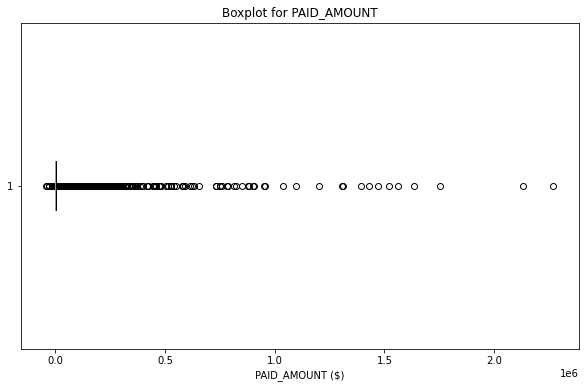

In [11]:
# Boxplot for PAID_AMOUNT
plt.figure(figsize=(10, 6))
plt.boxplot(claims_data['PAID_AMOUNT'], vert=False)
plt.title('Boxplot for PAID_AMOUNT')
plt.xlabel('PAID_AMOUNT ($)')
plt.show()

The plot displays the monthly trends in the total PAID_AMOUNT with anomalies highlighted in red.

Observations:
<ul>
    <li>
        The anomalies, represented by red 'x' markers, show significant deviations from the overall monthly trend.
    </li>
    <li>
        These anomalies are scattered across various months and represent exceptionally high claim amounts.
    </li>
</ul>
    

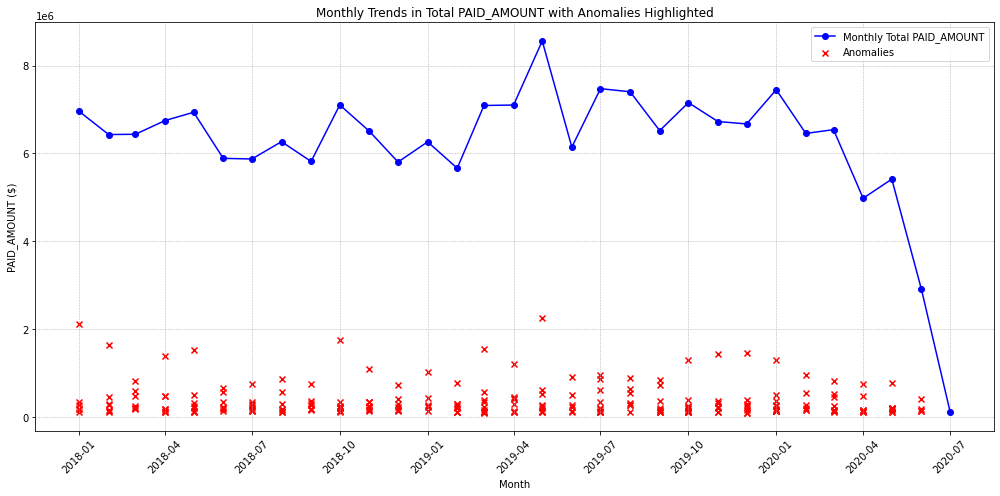

In [12]:
# Plotting monthly trends along with anomalies
plt.figure(figsize=(14, 7))
plt.plot(monthly_claims_updated['MONTH'], monthly_claims_updated['PAID_AMOUNT'], marker='o', color='b', linestyle='-', label='Monthly Total PAID_AMOUNT')
plt.scatter(anomalies['MONTH'], anomalies['PAID_AMOUNT'], color='r', marker='x', label='Anomalies')
plt.title('Monthly Trends in Total PAID_AMOUNT with Anomalies Highlighted')
plt.xlabel('Month')
plt.ylabel('PAID_AMOUNT ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Trends and projections for the upcoming 6 months.

The plot displays the monthly trends in the total PAID_AMOUNT alongside a 12-month moving average.

There has been a significant decline over the past three months, likely due to the COVID pandemic. I've removed the data from these months because they exhibit anomalous behavior, making them unsuitable for generating projections and establishing trends.

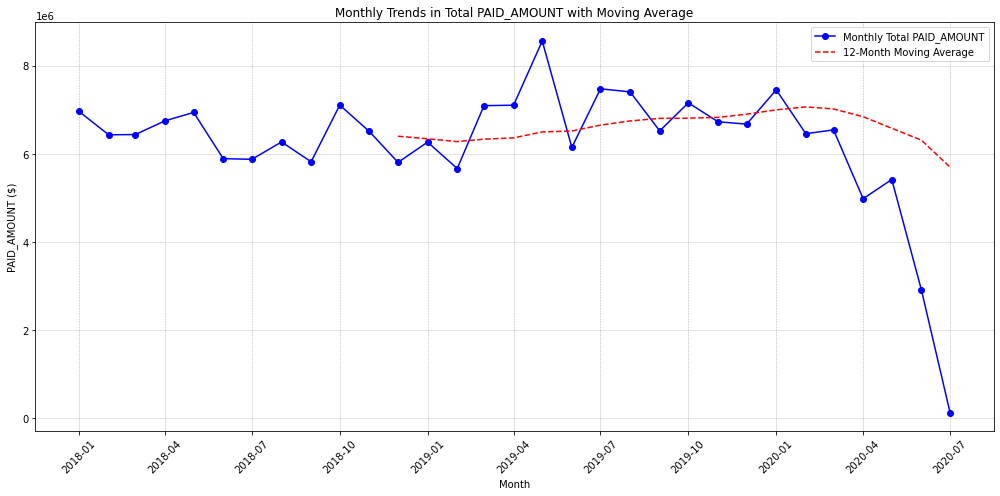

In [13]:
# Calculating a 12-month moving average for PAID_AMOUNT
monthly_claims_updated['Moving_Avg'] = monthly_claims_updated['PAID_AMOUNT'].rolling(window=12).mean()

# Plotting monthly total PAID_AMOUNT with moving average
plt.figure(figsize=(14, 7))
plt.plot(monthly_claims_updated['MONTH'], monthly_claims_updated['PAID_AMOUNT'], marker='o', color='b', linestyle='-', label='Monthly Total PAID_AMOUNT')
plt.plot(monthly_claims_updated['MONTH'], monthly_claims_updated['Moving_Avg'], color='r', linestyle='--', label='12-Month Moving Average')
plt.title('Monthly Trends in Total PAID_AMOUNT with Moving Average')
plt.xlabel('Month')
plt.ylabel('PAID_AMOUNT ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Filtering out data after March 2020
claims_data_filtered = claims_data[claims_data['MONTH'] <= '2020-03-31']

# Grouping by MONTH and summing PAID_AMOUNT to get total claims per month for the filtered data
monthly_claims_filtered = claims_data_filtered.groupby('MONTH')['PAID_AMOUNT'].sum().reset_index()

#monthly_claims_filtered.head()

The plot displays the monthly trends in the total PAID_AMOUNT alongside a 12-month moving average for the filtered data (up to March 2020):

<b>Monthly Total PAID_AMOUNT:</b>
<ul>
    <li>The claim amounts fluctuate over time, with some peaks and troughs evident.
            </li>
    <li>
We can observe an increasing trend in the early months, followed by some decrease, and then another increasing trend.
    </li>
</ul>

<b>12-Month Moving Average:</b>
<ul>
    <li>
The red dashed line represents the 12-month moving average, which helps in smoothing out short-term fluctuations and reveals longer-term trends.
    </li>
    <li>
The moving average suggests a generally increasing trend in the claim amounts over the years, with some periods of relative stability.
    </li>
</ul>

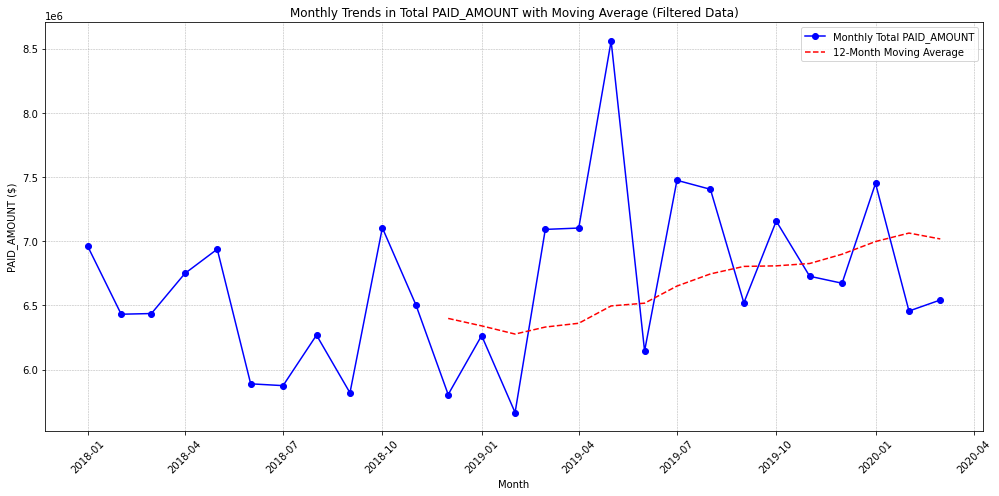

In [15]:
# Calculating a 12-month moving average for PAID_AMOUNT for the filtered data
monthly_claims_filtered['Moving_Avg'] = monthly_claims_filtered['PAID_AMOUNT'].rolling(window=12).mean()

# Plotting monthly total PAID_AMOUNT with moving average for the filtered data
plt.figure(figsize=(14, 7))
plt.plot(monthly_claims_filtered['MONTH'], monthly_claims_filtered['PAID_AMOUNT'], marker='o', color='b', linestyle='-', label='Monthly Total PAID_AMOUNT')
plt.plot(monthly_claims_filtered['MONTH'], monthly_claims_filtered['Moving_Avg'], color='r', linestyle='--', label='12-Month Moving Average')
plt.title('Monthly Trends in Total PAID_AMOUNT with Moving Average (Filtered Data)')
plt.xlabel('Month')
plt.ylabel('PAID_AMOUNT ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The plot displays the monthly total PAID_AMOUNT broken down by year for the filtered data (up to March 2020):

<b>Seasonal Patterns:</b>
<ul>
    <li>
        While there's some variability in the monthly amounts across years, certain patterns appear consistent. For instance, there's a noticeable increase around the middle of the year in both 2018 and 2019.
    </li>
    <li>
This suggests some level of seasonality in the claim amounts.
    </li>
</ul>
<b>Yearly Variation:</b>
<ul>
    <li>
The magnitude of claim amounts seems to differ from one year to the next. For instance, the peaks in 2019 appear higher than those in 2018.
    </li>
    <li>
This indicates that while there's a seasonal pattern, the overall volume of claims may be increasing year over year.
     </li>
</ul>  
    
In summary, for the filtered dataset (up to March 2020), there's both a seasonal pattern within each year and an overall upward trend over the years. This insight can be beneficial for planning and forecasting purposes.

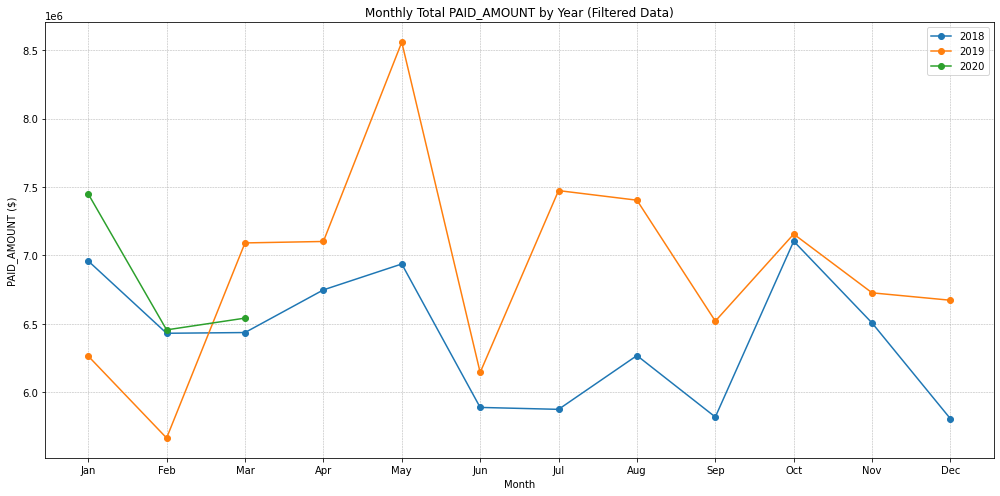

In [16]:
# Extracting year and month from the MONTH column for the filtered data
monthly_claims_filtered['Year'] = monthly_claims_filtered['MONTH'].dt.year
monthly_claims_filtered['Month_num'] = monthly_claims_filtered['MONTH'].dt.month

# Plotting monthly totals by year to observe seasonality for the filtered data
plt.figure(figsize=(14, 7))
for year in monthly_claims_filtered['Year'].unique():
    subset = monthly_claims_filtered[monthly_claims_filtered['Year'] == year]
    plt.plot(subset['Month_num'], subset['PAID_AMOUNT'], marker='o', label=year)

plt.title('Monthly Total PAID_AMOUNT by Year (Filtered Data)')
plt.xlabel('Month')
plt.ylabel('PAID_AMOUNT ($)')
plt.legend()
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Six months projection

To forecast the PAID_AMOUNT for the upcoming 6 months, various time series forecasting methods can be employed. One of the most widely used methods for time series forecasting is the ARIMA model (Autoregressive Integrated Moving Average). The ARIMA model captures different aspects of the time series data, such as trend, seasonality, and noise, to make predictions.

In [17]:
# Fit the ARIMA model 
model = ARIMA(monthly_claims_filtered['PAID_AMOUNT'], order=(5,1,0)) # Using (p,d,q) parameters which may need further optimization

model_fit = model.fit()

# Forecasting the next 6 months
forecast = model_fit.forecast(steps=6)

# Adding the forecasted data to the original data for visualization
forecast_dates = [monthly_claims_filtered['MONTH'].iloc[-1] + DateOffset(months=i) for i in range(1, 7)]
forecast_data = pd.DataFrame({
    'MONTH': forecast_dates,
    'PAID_AMOUNT': forecast
})

full_data_with_forecast = pd.concat([monthly_claims_filtered, forecast_data], axis=0)

#full_data_with_forecast.tail(7)  # Displaying last month of actual data and the 6 forecasted months


The ARIMA model has been used to forecast the PAID_AMOUNT for the next 6 months after March 2020. Here are the projections:

April 2020: Approximately &dollar;6,601,287

May 2020: Approximately &dollar;6,514,233

June 2020: Approximately &dollar;6,522,795

July 2020: Approximately &dollar;6,626,140

August 2020: Approximately &dollar;6,585,591

September 2020: Approximately &dollar;6,593,958

<br>Here's the visualization of the historical data along with the forecasted values:</br>
<br>The blue line represents the actual monthly PAID_AMOUNT.</br>
<br>The red dashed line is the 12-month moving average, providing a view of the long-term trend.</br>
<br>The green dash-dot line is the 3-month moving average, capturing more immediate fluctuations in the data.</br>
<br>The gray vertical line marks the start of the forecast period.</br>
<br>The orange 'x' markers represent the forecasted PAID_AMOUNT for the next six months.</br>
<br>From the forecast, we observe a general continuation of the trend seen in the earlier data. The forecasted values, while showing some fluctuation, generally align with the previously observed patterns in the data.</br>

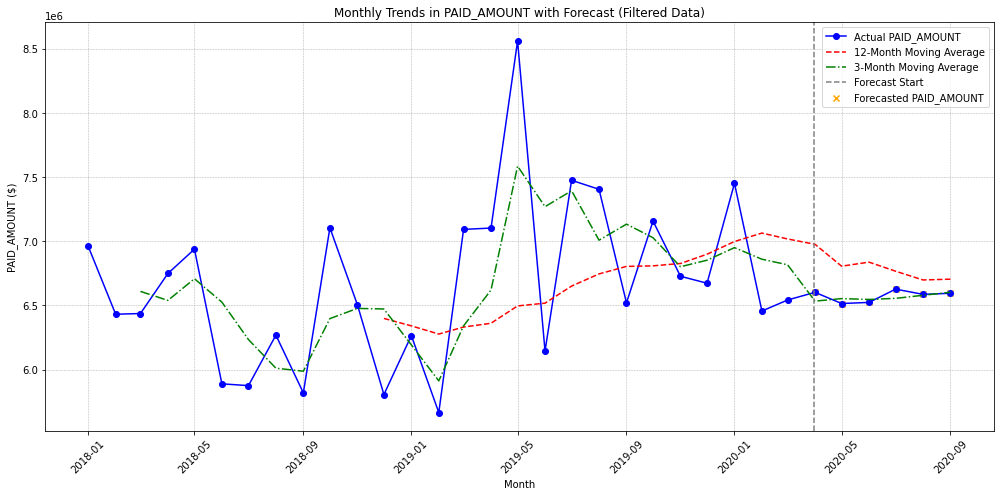

In [18]:
# Plotting the historical data along with the forecasted values with corrected date format for axvline
plt.figure(figsize=(14, 7))
plt.plot(full_data_with_forecast['MONTH'], full_data_with_forecast['PAID_AMOUNT'], marker='o', color='b', linestyle='-', label='Actual PAID_AMOUNT')
plt.plot(full_data_with_forecast['MONTH'], full_data_with_forecast['PAID_AMOUNT'].rolling(window=12).mean(), color='r', linestyle='--', label='12-Month Moving Average')
plt.plot(full_data_with_forecast['MONTH'], full_data_with_forecast['PAID_AMOUNT'].rolling(window=3).mean(), color='g', linestyle='-.', label='3-Month Moving Average')
plt.axvline(x=pd.Timestamp('2020-03-31'), color='gray', linestyle='--', label='Forecast Start')
plt.scatter(forecast_data['MONTH'], forecast_data['PAID_AMOUNT'], color='orange', marker='x', label='Forecasted PAID_AMOUNT')
plt.title('Monthly Trends in PAID_AMOUNT with Forecast (Filtered Data)')
plt.xlabel('Month')
plt.ylabel('PAID_AMOUNT ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
